In [1]:
# Autoencoder for Image Denoising using PyTorch

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

In [3]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
# Transform: Normalize and convert to tensor
transform = transforms.Compose([
    transforms.ToTensor()
])



In [5]:
# Load MNIST dataset
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.90MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 129kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.75MB/s]


In [6]:
# Add noise to images
def add_noise(inputs, noise_factor=0.5):
    noisy = inputs + noise_factor * torch.randn_like(inputs)
    return torch.clamp(noisy, 0., 1.)


In [9]:
# Define Autoencoder
class DenoisingAutoencoder(nn.Module):
    def __init__(self): # Changed _init_ to __init__
        super(DenoisingAutoencoder, self).__init__()
        # Define your layers here
        # Example:
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()  # For reconstruction, sigmoid is often used
        )
    def forward(self, x):
        # Include your code here
        x = x.view(-1, 28*28)  # Flatten the input image
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1, 1, 28, 28)  # Reshape to image dimensions
        return x

In [10]:
#Initialize model, loss function and optimizer
model = DenoisingAutoencoder().to(device)
summary(model, (1, 28, 28))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
              ReLU-2                  [-1, 128]               0
            Linear-3                   [-1, 64]           8,256
              ReLU-4                   [-1, 64]               0
            Linear-5                   [-1, 12]             780
              ReLU-6                   [-1, 12]               0
            Linear-7                    [-1, 3]              39
            Linear-8                   [-1, 12]              48
              ReLU-9                   [-1, 12]               0
           Linear-10                   [-1, 64]             832
             ReLU-11                   [-1, 64]               0
           Linear-12                  [-1, 128]           8,320
             ReLU-13                  [-1, 128]               0
           Linear-14                  [

In [11]:
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
              ReLU-2                  [-1, 128]               0
            Linear-3                   [-1, 64]           8,256
              ReLU-4                   [-1, 64]               0
            Linear-5                   [-1, 12]             780
              ReLU-6                   [-1, 12]               0
            Linear-7                    [-1, 3]              39
            Linear-8                   [-1, 12]              48
              ReLU-9                   [-1, 12]               0
           Linear-10                   [-1, 64]             832
             ReLU-11                   [-1, 64]               0
           Linear-12                  [-1, 128]           8,320
             ReLU-13                  [-1, 128]               0
           Linear-14                  [

In [13]:
# Train the autoencoder
def train(model, loader, criterion, optimizer, epochs=5):
    # Include your code here
    model.train() # Set the model to training mode
    for epoch in range(epochs):
        for batch_idx, (data, _) in enumerate(loader):
            data = data.to(device)
            noisy_data = add_noise(data)  # Add noise to the input data
            optimizer.zero_grad()
            output = model(noisy_data)
            loss = criterion(output, data)  # Calculate loss
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Step [{batch_idx+1}/{len(loader)}], Loss: {loss.item():.4f}')

In [15]:
# Evaluate and visualize
def visualize_denoising(model, loader, num_images=10):
    model.eval()
    with torch.no_grad():
        for images, _ in loader:
            images = images.to(device)
            noisy_images = add_noise(images).to(device)
            outputs = model(noisy_images)
            break

    images = images.cpu().numpy()
    noisy_images = noisy_images.cpu().numpy()
    outputs = outputs.cpu().numpy()

    print("Name: Priyadharshini.P                ")
    print("Register Number: 212223240128             ")
    plt.figure(figsize=(18, 6))
    for i in range(num_images):
        # Original
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title("Original")
        plt.axis("off")

        # Noisy
        ax = plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(noisy_images[i].squeeze(), cmap='gray')
        ax.set_title("Noisy")
        plt.axis("off")

        # Denoised
        ax = plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(outputs[i].squeeze(), cmap='gray')
        ax.set_title("Denoised")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


Epoch [1/5], Step [1/469], Loss: 0.2319
Epoch [1/5], Step [101/469], Loss: 0.0686
Epoch [1/5], Step [201/469], Loss: 0.0661
Epoch [1/5], Step [301/469], Loss: 0.0578
Epoch [1/5], Step [401/469], Loss: 0.0614
Epoch [2/5], Step [1/469], Loss: 0.0558
Epoch [2/5], Step [101/469], Loss: 0.0549
Epoch [2/5], Step [201/469], Loss: 0.0551
Epoch [2/5], Step [301/469], Loss: 0.0520
Epoch [2/5], Step [401/469], Loss: 0.0544
Epoch [3/5], Step [1/469], Loss: 0.0533
Epoch [3/5], Step [101/469], Loss: 0.0534
Epoch [3/5], Step [201/469], Loss: 0.0529
Epoch [3/5], Step [301/469], Loss: 0.0535
Epoch [3/5], Step [401/469], Loss: 0.0529
Epoch [4/5], Step [1/469], Loss: 0.0507
Epoch [4/5], Step [101/469], Loss: 0.0490
Epoch [4/5], Step [201/469], Loss: 0.0523
Epoch [4/5], Step [301/469], Loss: 0.0475
Epoch [4/5], Step [401/469], Loss: 0.0495
Epoch [5/5], Step [1/469], Loss: 0.0496
Epoch [5/5], Step [101/469], Loss: 0.0475
Epoch [5/5], Step [201/469], Loss: 0.0486
Epoch [5/5], Step [301/469], Loss: 0.0484
Ep

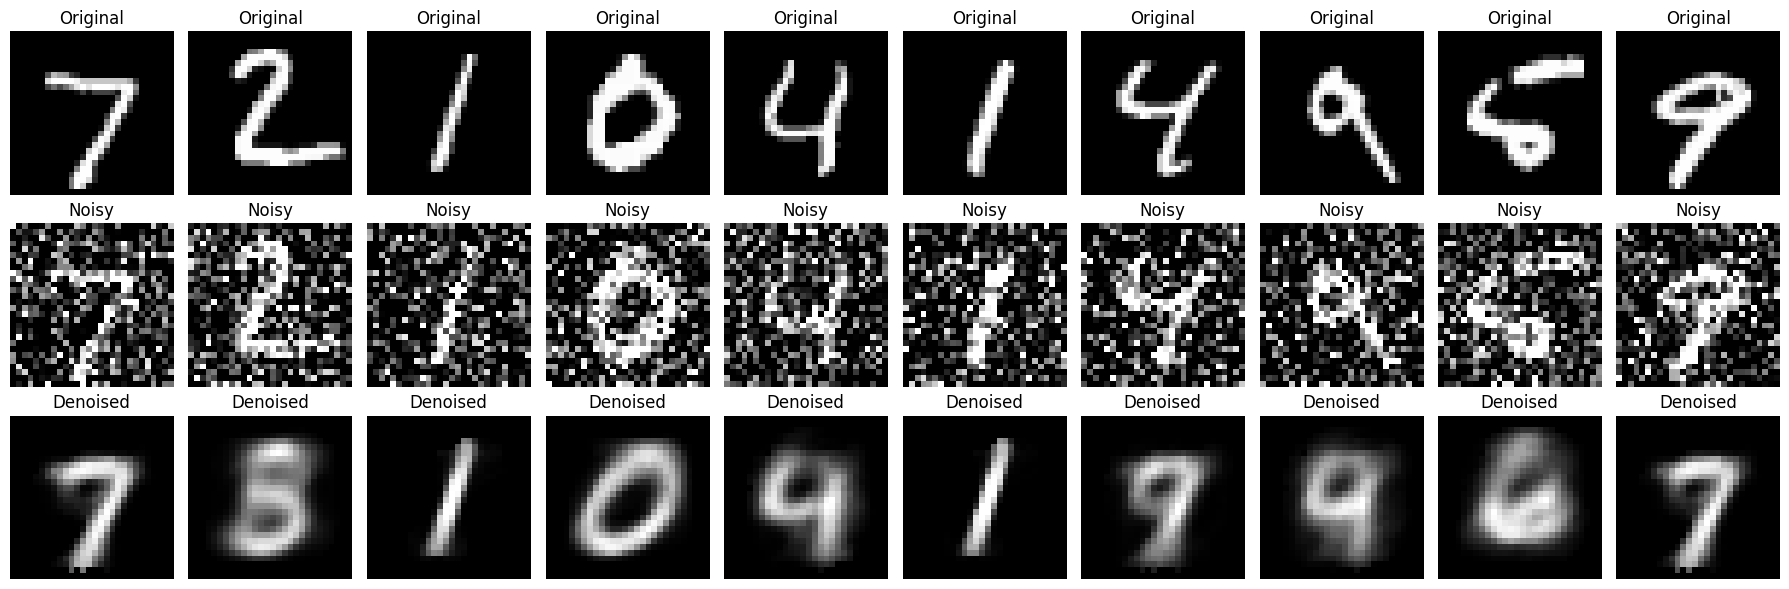

In [16]:
# Run training and visualization
train(model, train_loader, criterion, optimizer, epochs=5)
visualize_denoising(model, test_loader)